In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Take a glance at the provided data 

raw_data = pd.read_excel('data/dataset.xlsx', engine="openpyxl")

raw_data.info()
raw_data.describe()
raw_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644 entries, 0 to 5643
Columns: 111 entries, Patient ID to ctO2 (arterial blood gas analysis)
dtypes: float64(70), int64(4), object(37)
memory usage: 4.8+ MB


,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


----

> Data Observation

The provided data contains 111 entries totally. The 3rd to 6th columns (```SARS-Cov-2 exam result```, etc) are the labels we want to predict. Other columns are features we can exploit to predict corresponding labels. However, these features look messed up now because many values of them are missing or intractable.

In [3]:
# Data preprocessing

raw_data.columns = [x.lower().strip().replace(' ','_') for x in raw_data.columns]

def show_missing_features(x):
    total = x.isnull().sum()
    percent = (x.isnull().sum()/x.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in raw_data.columns:
        dtype = str(x[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

show_missing_features(raw_data)

,patient_id,patient_age_quantile,sars-cov-2_exam_result,"patient_addmited_to_regular_ward_(1=yes,_0=no)","patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)","patient_addmited_to_intensive_care_unit_(1=yes,_0=no)",hematocrit,hemoglobin,platelets,mean_platelet_volume,...,hb_saturation_(arterial_blood_gases),pco2_(arterial_blood_gas_analysis),base_excess_(arterial_blood_gas_analysis),ph_(arterial_blood_gas_analysis),total_co2_(arterial_blood_gas_analysis),hco3_(arterial_blood_gas_analysis),po2_(arterial_blood_gas_analysis),arteiral_fio2,phosphor,cto2_(arterial_blood_gas_analysis)
Total,0,0,0,0,0,0,5041,5041,5042,5045,...,5617,5617,5617,5617,5617,5617,5617,5624,5624,5617
Percent,0.0,0.0,0.0,0.0,0.0,0.0,89.316088,89.316088,89.333806,89.38696,...,99.521616,99.521616,99.521616,99.521616,99.521616,99.521616,99.521616,99.645641,99.645641,99.521616
Types,object,int64,object,int64,int64,int64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


---

> Fill Missing Cells

From the table above, we can clearly see the data type and missing percentage of each feature. A simple approach is filling missing cells with the mean value of existing non-nan cells, or a constant. As for label-typed features, we use ```LabelEncoder```. See [sklearn.preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html) for more details!

In [4]:
# Fill in missing features

for x in raw_data.columns:
    if raw_data[x].dtype=='float16' or  raw_data[x].dtype=='float32' or  raw_data[x].dtype=='float64':
        raw_data[x].fillna(raw_data[x].mean())

raw_data = raw_data.fillna(-999)

# Convert label-typed features
for y in raw_data.columns:
    if raw_data[y].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(raw_data[y].values))
        raw_data[y] = lbl.transform(list(raw_data[y].values))

raw_data.head()

,patient_id,patient_age_quantile,sars-cov-2_exam_result,"patient_addmited_to_regular_ward_(1=yes,_0=no)","patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)","patient_addmited_to_intensive_care_unit_(1=yes,_0=no)",hematocrit,hemoglobin,platelets,mean_platelet_volume,...,hb_saturation_(arterial_blood_gases),pco2_(arterial_blood_gas_analysis),base_excess_(arterial_blood_gas_analysis),ph_(arterial_blood_gas_analysis),total_co2_(arterial_blood_gas_analysis),hco3_(arterial_blood_gas_analysis),po2_(arterial_blood_gas_analysis),arteiral_fio2,phosphor,cto2_(arterial_blood_gas_analysis)
0,1588,13,0,0,0,0,-999.000000,-999.00000,-999.000000,-999.000000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,451,17,0,0,0,0,0.236515,-0.02234,-0.517413,0.010677,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
2,3669,8,0,0,0,0,-999.000000,-999.00000,-999.000000,-999.000000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,5457,5,0,0,0,0,-999.000000,-999.00000,-999.000000,-999.000000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
4,4843,15,0,0,0,0,-999.000000,-999.00000,-999.000000,-999.000000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0


---

> Feature Engineering

Feature engineering is always the most time-consuming and energy-consuming part of data analysis. And it is not a deterministic step like algorithms and models, but more about engineering experience and trade-offs. 

Here we provide a simple intuition to select useful features: we calculate the correlations between each feature as the covariance matrix, and then remove the features highly correlated with others (which means this column can be easily linear-combined by others). 

In [5]:
# Calculate the covariance matrix

corr_matrix = raw_data.corr().abs()
corr_matrix.head()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,patient_id,patient_age_quantile,sars-cov-2_exam_result,"patient_addmited_to_regular_ward_(1=yes,_0=no)","patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)","patient_addmited_to_intensive_care_unit_(1=yes,_0=no)",hematocrit,hemoglobin,platelets,mean_platelet_volume,...,hb_saturation_(arterial_blood_gases),pco2_(arterial_blood_gas_analysis),base_excess_(arterial_blood_gas_analysis),ph_(arterial_blood_gas_analysis),total_co2_(arterial_blood_gas_analysis),hco3_(arterial_blood_gas_analysis),po2_(arterial_blood_gas_analysis),arteiral_fio2,phosphor,cto2_(arterial_blood_gas_analysis)
patient_id,NaN,0.014136,0.018664,0.003748,0.004803,0.000162,0.002173,0.002167,0.001974,0.002017,...,0.002856,0.002832,0.002847,0.002854,0.002839,0.002840,0.002850,0.005929,0.007077,0.002847
patient_age_quantile,NaN,NaN,0.075244,0.046166,0.015736,0.035772,0.109140,0.109128,0.109860,0.107703,...,0.051720,0.051703,0.051778,0.051778,0.051743,0.051749,0.051730,0.050366,0.020413,0.051732
sars-cov-2_exam_result,NaN,NaN,NaN,0.142437,0.019364,0.027586,0.044974,0.044976,0.045045,0.042017,...,0.088889,0.088836,0.088889,0.088910,0.088845,0.088849,0.088910,0.070122,0.009768,0.088905
"patient_addmited_to_regular_ward_(1=yes,_0=no)",NaN,NaN,NaN,NaN,0.011264,0.010192,0.241889,0.241885,0.242051,0.238041,...,0.144795,0.144685,0.144753,0.144797,0.144703,0.144710,0.144771,0.145138,0.007105,0.144815
"patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)",NaN,NaN,NaN,NaN,NaN,0.008087,0.224213,0.224218,0.224609,0.225239,...,0.267281,0.267521,0.267400,0.267417,0.267440,0.267432,0.267359,0.153438,0.185337,0.267463


In [6]:
threshold = 0.92
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))
dataset = raw_data.drop(columns = to_drop) # dropped data
print('Data shape: ', raw_data.shape)
print('Size of the cleaned data', dataset.shape)

There are 64 columns to remove.
Data shape:  (5644, 111)
Size of the cleaned data (5644, 47)


In [7]:
# Dataset contains selected features

dataset.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644 entries, 0 to 5643
Columns: 47 entries, patient_id to phosphor
dtypes: float64(30), int64(17)
memory usage: 2.0 MB


---

> **TODO**

**Try to Select or Create Meanful Features from ```raw_data```.**

For example, try dimensionality reduction methods like [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) or [NMF](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization#:~:text=Non-negative) or [Tree-Based models](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree) to weight feature's importance. These tools can be easily found in [scikit-learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition). But it is more encouraged for you to understand the principle behind them and implement them by yourself.

> Requirements
* Conduct feature engineering by using [scikit-learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) or your own implementation.
* Compare the final test results obtained by your method in your report. 
* Note that you should first read through and complete other parts of this notebook so that you can start for comparison.

---

> Create Dataset and Split Train/Test Data

The following part builds up our dataset and split them into Train/Test Splits.

In [8]:
label_col = ['patient_id','sars-cov-2_exam_result', 'patient_addmited_to_regular_ward_(1=yes,_0=no)', 'patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)', 'patient_addmited_to_intensive_care_unit_(1=yes,_0=no)']
cols = [x for x in dataset.columns if x not in label_col] # These columns are the features we can use to predict

In [9]:
X = dataset[cols]
X.head()

,patient_age_quantile,hematocrit,serum_glucose,respiratory_syncytial_virus,mycoplasma_pneumoniae,neutrophils,urea,proteina_c_reativa_mg/dl,potassium,"influenza_b,_rapid_test",...,"prothrombin_time_(pt),_activity",vitamin_b12,creatine_phosphokinase (cpk),ferritin,arterial_lactic_acid,lipase_dosage,d-dimer,albumin,arteiral_fio2,phosphor
0,13,-999.000000,-999.000000,0,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,17,0.236515,-0.140648,2,-999.0,-0.619086,1.198059,-0.147895,-0.305787,1,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
2,8,-999.000000,-999.000000,0,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,5,-999.000000,-999.000000,0,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
4,15,-999.000000,-999.000000,2,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0


In [10]:
y = dataset['sars-cov-2_exam_result'] # predict ```sars-cov-2_exam_result``` (Negative/Positive)

# random split to Train/Test with the ratio of 2:1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=101) # fixed random seed

---

> **TODO**

**Select and Train Your Model on ```X_train``` and ```y_train```**

We provide an example of ```LogisticRegression``` and ```DecisionTreeClassifier```. Now it's time for your to select the model you like to conduct classification.

> Requirements
* Select at least **three** other Machine Learning models and train them on the Train split. And you should implement at least **one** by yourself.

In [11]:
accuracy_lst =[]

def model_assess(model, name='Default'):
    model.fit(X_train, y_train)
    prds = model.predict(X_test)
    model_acc = accuracy_score(y_test, prds)
    accuracy_lst.append(100*model_acc)
    print('Accuracy:', (accuracy_score(y_test, prds)), '\n')

In [12]:
# Logistic Regression
lg = LogisticRegression()
model_assess(lg, 'Logistic Regression')

Accuracy: 0.9023081052066559 



In [13]:
# Decision Tree
tree = DecisionTreeClassifier()
model_assess(tree, 'Decission Trees')

Accuracy: 0.8964036500268384 



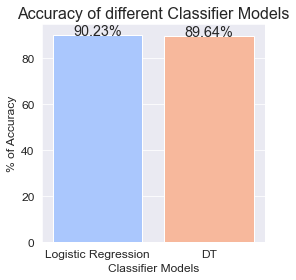

In [14]:
# Demostrate model results on Train split

model_list = ['Logistic Regression', 'DT']

plt.rcParams['figure.figsize']=4,4
sns.set_style('darkgrid')
ax = sns.barplot(x=model_list, y = accuracy_lst, palette = "coolwarm", saturation =2.0)
plt.xlabel('Classifier Models', fontsize = 12)
plt.ylabel('% of Accuracy', fontsize = 12)
plt.title('Accuracy of different Classifier Models', fontsize = 16)
plt.xticks(fontsize = 12, horizontalalignment = 'center')
plt.yticks(fontsize = 12)
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy() 
    ax.annotate(f'{round(height,2)}%', (x + width/2, y + height), ha='center', fontsize = 'x-large')
plt.show()

In [15]:
# Cross-validaiton

cross_acc = []

ca_lg = cross_val_score(lg, X_train, y_train, scoring='accuracy')
ca_lg = ca_lg.mean()
cross_acc.append(100*ca_lg)

ca_tree = cross_val_score(tree, X_train, y_train, scoring='accuracy')
ca_tree = ca_tree.mean()
cross_acc.append(100*ca_tree)

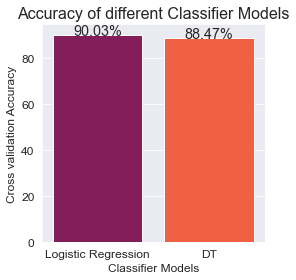

In [16]:
# Demostrate model results on Test split

plt.rcParams['figure.figsize']=4,4
sns.set_style('darkgrid')
ax = sns.barplot(x=model_list, y=cross_acc, palette = "rocket", saturation =2.0)
plt.xlabel('Classifier Models', fontsize = 12 )
plt.ylabel('Cross validation Accuracy', fontsize = 12)
plt.title('Accuracy of different Classifier Models', fontsize = 16)
plt.xticks(fontsize = 12, horizontalalignment = 'center')
plt.yticks(fontsize = 12)
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy() 
    ax.annotate(f'{round(height,2)}%', (x + width/2, y + height), ha='center', fontsize = 'x-large')
plt.show()

---

> **TODO**

**Tune Model for Good Performance on Test Split**

The final objective for training is to obtain a model that performs well on the unseen Test split (not to overfit the Train split). Now it is your time to provide the final solution.

> Requirements
* Try more evaluation methods (like Confusion Matrix, AUC curve and etc.) to make your results more convincing.
* Tune model's hyperparameters by cross-validation and evaluate all your selected models. And give a detailed report on the performance and computational efficiency.
* It is appreciated if other machine learning techniques that help to improve performance are employed.

---

> **TODO**

**Try to Predict for Another Task**

Now, your are familiar with the simple pipeline of data mining. The final task for you is to explore the ```data/dataset.xlsx``` to predict one of the labels above:
* ```patient_addmited_to_regular_ward_(1=yes,_0=no)```
* ```patient_addmited_to_semi-intensive_unit_(1=yes,_0=no)```
* ```patient_addmited_to_intensive_care_unit_(1=yes,_0=no)```

> Requirements
* Use **Row 5001-5645** of ```data/dataset.xlsx``` as the Test Split. Write code or a jupyter notebook to show how you solve this task. Please give detailed comments of your code and a good demonstration of your results.


---